# 43008: Reinforcement Learning

## Week 7: Temporal-Difference Methods:
## Part A: Temporal Difference Prediction

* TD Prediction - TD(0) Policy Evaluation

### What you will learn?
* Implement TD(0) Policy Evaluation Algorithm

## 1. Imports and Utilities




In [1]:
!pip install gymnasium pyvirtualdisplay
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 https://cli.github.com/packages stable InRelease
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [80.4 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,002 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,241 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy/main amd64 Packages [43.0 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,7

In [2]:
# moviepy is not installed, run `pip install "gymnasium[other]"`
!pip install gymnasium[other]
!pip install gymnasium[toy-text]

In [3]:
import sys
import gymnasium as gym
import numpy as np
import random
import glob
import io
import base64
from collections import defaultdict
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML
from pyvirtualdisplay import Display
import os # Import the os module

display = Display(visible=0, size=(1400, 900))
display.start()

### Utility Functions




#### Plot Values

In [4]:
def plot_values(V, shape):
    # Reshape the value function V to the given shape
    V = np.reshape(V, shape)

    # Create a new figure with a specific size
    fig = plt.figure(figsize=(15,5))

    # Add a subplot to the figure. 111 means 1x1 grid, first subplot.
    ax = fig.add_subplot(111)

    # Display the reshaped value function V as an image on the axes
    im = ax.imshow(V, cmap='cool')

    # For each value in V, annotate the plot with the value's rounded label
    for (j,i),label in np.ndenumerate(V):
        ax.text(i, j, np.round(label,3), ha='center', va='center', fontsize=14)

    # Disable ticks and tick labels for both x and y axes
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')

    # Set the title for the plot
    plt.title('State-Value Function')

    # Display the plot
    plt.show()


#### Simulate and show video

In [5]:
def simulate_and_show_video(env_id, p):
    """
    Simulate an environment using a given policy and display the video.

    Parameters:
    - env_id: The string ID of the environment to simulate.
    - p: The policy to use for taking actions.

    Returns:
    - HTML object if video was captured, or a message indicating no videos were found.
    """
    video_folder = f"./{env_id}_videos"

    # Create the environment with the specified render_mode and wrap it
    # The RecordVideo wrapper handles the video creation.
    env = gym.make(env_id, render_mode='rgb_array')
    env = RecordVideo(env, video_folder=video_folder)

    state, info = env.reset()
    done = False

    while not done:
        action = p(env, state)
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

    # Close the environment, which finalizes the video recording.
    env.close()

    # Look for the '.mp4' files in the correct directory
    mp4list = glob.glob(f'{video_folder}/*.mp4')

    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)

        # Clean up the directory after displaying the video
        for file in mp4list:
            os.remove(file)
        os.rmdir(video_folder)

        return HTML(data=f'''<video alt="test" autoplay loop controls style="height: 400px;">
                        <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
                      </video>''')
    else:
        return "No videos found or error during video creation."

## 2. TD(0) Prediction Algorithm



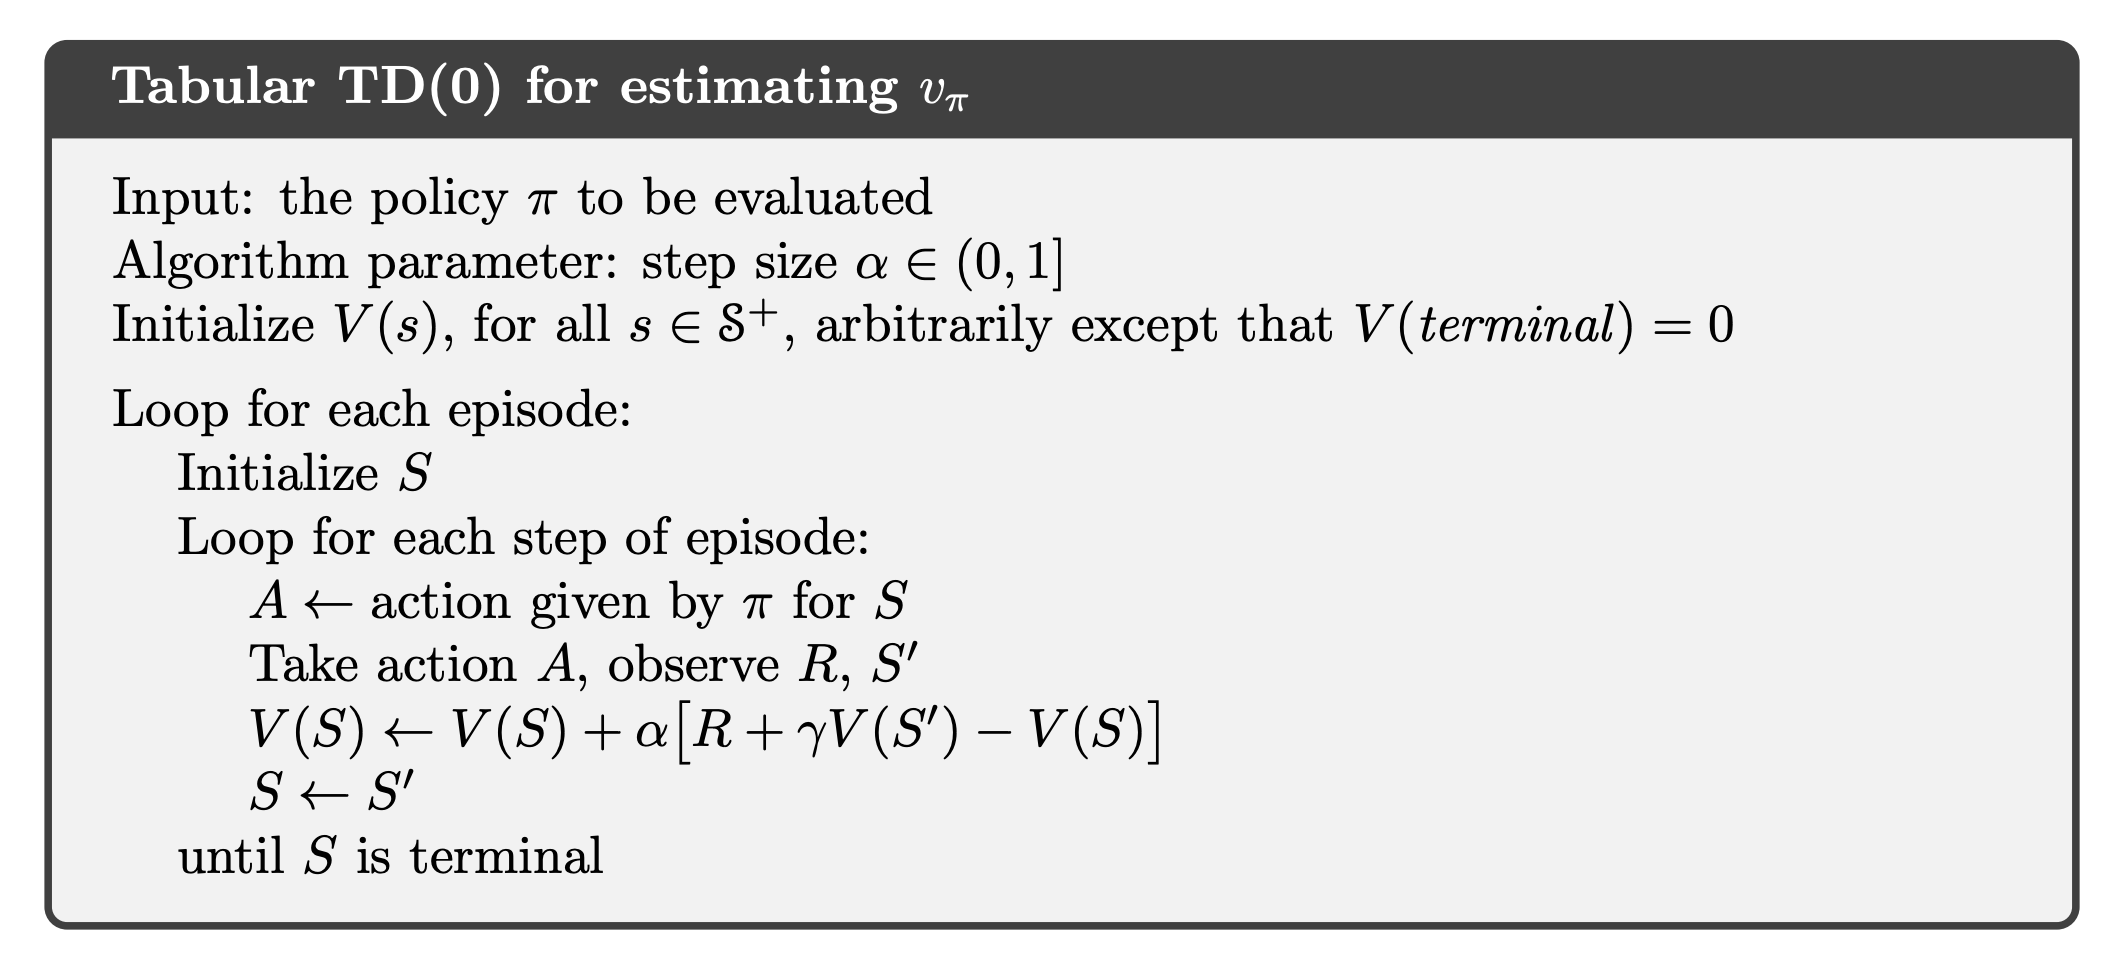

### Define a random policy (random actions)

In [6]:
# Define a random policy.
def random_policy(state):
    """
    A policy that randomly chooses an action.

    Args:
        state: Current state (not used in this policy since it's random).

    Returns:
        action: A random action.
    """
    return env.action_space.sample()

### Define a deterministic policy for Cliffwalking Environment

In [7]:
def cliffwalking_deterministic_policy(env, state):
    """
    Deterministic policy for the CliffWalking environment.
    Always move right until the last column, then move down.

    Args:
        state: Current state (can be a tuple in newer gym versions).

    Returns:
        action: Chosen action.
    """
    # In the CliffWalking environment:
    # 0: up, 1: right, 2: down, 3: left
    width = 12  # width of the CliffWalking grid
    last_column = width - 1

    # If state is a tuple, extract the actual state
    if isinstance(state, tuple):
        state = state[0]

    # Convert state to (row, column) format
    row, col = divmod(state, width) # divmod(dividend, divisor)

    # If in the last column, move down. Otherwise, move right.
    if state == 36: # Assuming 36 is the goal state in the CliffWalking env
        return 0 # Up, or any action that ends the episode if it's a terminal state. The original code had 0 (up) here, which might be incorrect depending on the environment's terminal state handling. Let's keep it as 0 for now, assuming the episode ends.
    if col == last_column:
        return 2  # down
    else:
        return 1  # right

### Define a deterministic policy for Taxi Environment

In [8]:
def taxi_deterministic_policy(env, state):
    """
    Deterministic policy for the Taxi environment.
    Always move north until the first row, then move right,
    and pick up the passenger when at their location.

    Args:
        state: Current state.

    Returns:
        action: Chosen action.
    """
    # Decode the state to get row, column, passenger location, and destination.
    # Access the unwrapped environment to use the decode method
    row, col, passenger_location, destination = env.unwrapped.decode(state)

    # Check if the taxi is at the passenger's location and the passenger is not in the taxi
    # Only access env.unwrapped.locs if passenger_location is a valid index (0-3)
    if passenger_location < 4 and (row, col) == env.unwrapped.locs[passenger_location]:
        return 4  # pickup action
    # If in the first row, move right. Otherwise, move north.
    elif row == 0:
        return 2  # east (right)
    else:
        return 1  # north

### Implement TD(0) Policy Evaluation Algorithm

In [9]:
def td_0_policy_evaluation(env, policy, num_episodes, alpha=0.1, gamma=1.0):
    """
    Tabular Temporal-Difference (TD) Policy Evaluation using TD(0) for estimating V under policy pi.

    Args:
        env: OpenAI gym environment.
        policy: Policy (pi) to be evaluated.
        num_episodes: Number of episodes to run.
        alpha: Learning rate (step size).
        gamma: Discount factor.

    Returns:
        V: Estimated value function.
    """

    # Initialize the state-value function V for all states arbitrarily except terminal states.
    V = np.zeros(env.observation_space.n)
    print("Initial Value Function:", V)

    # Loop for each episode.
    for i_episode in range(num_episodes):
        print(f"\nEpisode {i_episode + 1} starting...")

        # Initialize the starting state of the episode.
        # env.reset() now returns (observation, info) in newer gym versions
        state, info = env.reset()
        print(f"Initial state: {state}")


        while True:
            # Choose action (A) based on the current policy (pi) for the given state.
            action = policy(env, state)
            #print(f"Action chosen for state {state}: {action}")

            # Take the chosen action in the environment, observe the reward (R), next state (S'), and done status.
            # env.step() now returns (observation, reward, terminated, truncated, info) in newer gym versions
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            #print(f"Next state: {next_state}, Reward received: {reward}, Done: {done}")

            # Update the value function using the TD error and the learning rate (alpha).
            old_value = V[state]
            V[state] += alpha * (reward + gamma * V[next_state] - V[state])
            #print(f"Value of state {state} updated from {old_value} to {V[state]}")


            # Update the current state to the next state.
            state = next_state

            # If the episode has ended (reached terminal state), break out of the loop.
            if done:
                print(f"Episode {i_episode + 1} finished.")
                break

    return V

## TD Prediction on the deterministic policy for CliffWalking

### Initialise the CliffWalking Environment

In [10]:
# Create the CliffWalking environment.
env = gym.make('CliffWalking-v1')

### Simulate using the policy

In [11]:
simulate_and_show_video('CliffWalking-v1', cliffwalking_deterministic_policy)

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"


### Run Policy Evaluation

In [12]:
# Evaluate the random policy using Tabular TD(0) policy evaluation for CliffWalking.
V_cliffwalking = td_0_policy_evaluation(env, cliffwalking_deterministic_policy, num_episodes=1000)

Initial Value Function: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Episode 1 starting...
Initial state: 36
Episode 1 finished.

Episode 2 starting...
Initial state: 36
Episode 2 finished.

Episode 3 starting...
Initial state: 36
Episode 3 finished.

Episode 4 starting...
Initial state: 36
Episode 4 finished.

Episode 5 starting...
Initial state: 36
Episode 5 finished.

Episode 6 starting...
Initial state: 36
Episode 6 finished.

Episode 7 starting...
Initial state: 36
Episode 7 finished.

Episode 8 starting...
Initial state: 36
Episode 8 finished.

Episode 9 starting...
Initial state: 36
Episode 9 finished.

Episode 10 starting...
Initial state: 36
Episode 10 finished.

Episode 11 starting...
Initial state: 36
Episode 11 finished.

Episode 12 starting...
Initial state: 36
Episode 12 finished.

Episode 13 starting...
Initial state: 36
Episode 13 finished.

Episode 14 starting...
Init

### Show Value function

In [13]:
print(V_cliffwalking)

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. -12. -11. -10.  -9.
  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1. -13.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.]


### Plot Value function for CliffWalking

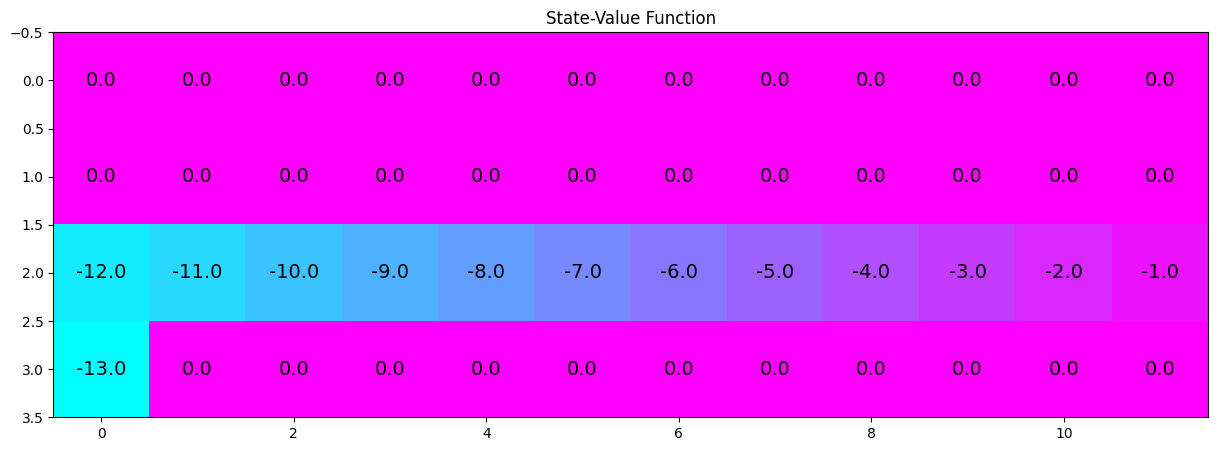

In [14]:
plot_values(V_cliffwalking, (4, 12))

## TD Prediction on the deterministic policy for Taxi Environment

### Initialise the Taxi Environment

In [15]:
# Create the Taxi environment.
env = gym.make('Taxi-v3')

### Simulate using the policy

In [16]:
simulate_and_show_video('Taxi-v3', taxi_deterministic_policy)

### Run Policy Evaluation

In [17]:
# Evaluate the random policy using Tabular TD(0) policy evaluation for Taxi.
V_taxi = td_0_policy_evaluation(env, taxi_deterministic_policy, num_episodes=1000)

Initial Value Function: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.

### Show Value function

In [18]:
print(V_taxi)

[ 0.00000000e+00 -8.22732547e+01 -4.31031512e+01 -9.01386395e+01
 -2.70392722e+02  0.00000000e+00 -4.66112818e+02 -1.62035905e+02
 -1.84309360e+02 -3.28996438e+02  0.00000000e+00 -1.54746671e+02
 -2.24902173e+02 -3.48973450e+02 -2.25037474e+02  0.00000000e+00
 -1.12273000e+01 -2.20110279e+02 -1.24248748e+02 -2.03228404e+02
  0.00000000e+00 -3.17200000e+02 -3.57100000e+02 -2.37300000e+02
 -6.52600000e+02  0.00000000e+00 -7.68800000e+02 -5.53500000e+02
 -5.93300000e+02 -6.92700000e+02  0.00000000e+00 -3.76500000e+02
 -5.32000000e+02 -6.71400000e+02 -5.73000000e+02  0.00000000e+00
 -7.76000000e+01 -3.90700000e+02 -2.75000000e+02 -3.72000000e+02
  0.00000000e+00 -4.06349060e+02 -4.67835652e+02 -2.47998444e+02
 -2.27843856e+02  0.00000000e+00 -1.76696518e+02 -2.15376248e+02
 -1.90007814e+02 -2.30472303e+02  0.00000000e+00 -5.16694972e+02
 -3.11698384e+02 -2.53946470e+02 -3.57060265e+02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -8.01338

#### Note: We cannot plot the value function as taxi has 500 states, which do not relate to the grid. Each grid box can have approximately 20 different states as it is a 5x5 grid world.

## Move to Part B